
<img src="https://article.images.consumerreports.org/c_lfill,w_1920,ar_32:11/prod/content/dam/CRO%20Images%202017/Cars/March/CR-Cars-Hero-Used-Car-Sales-03-17">



## <center> Used car price prediction </center>
### <center> Data analysis and predictive model building </center>
### <center> by Yuliya Klimushina, 2018

The data used in this project can be downloaded [here](https://www.kaggle.com/orgesleka/used-cars-database). The dataset contains information about used cars for sale on Ebay in March 2015-April 2016. The data is presented in German. The purpose of the study: to create a model that predicts the price of a car in the secondary market. This model can help:

- the owner of a car do not to sell it too cheap;
- the buyer do not overpay;
- the dealer who is engaged in reselling cars determine how profitable a particular offer is.

The same model can be used to predict another target value such a period within a car can be sold. Unfortunatelly there is no enough data to take into account seasonality of demand. For that type of problem it would be a good idea to use time series.     

In [558]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor 
from scipy.sparse import csr_matrix, hstack
import warnings
warnings.filterwarnings('ignore')

In [559]:
RANDOM_SEED = 17
sns.set_palette('Blues_d')

### Dataset and features description

#### Features:
- **dateCrawled**: date and time when the ad was first viewed 
- **name** : the name of the car (formed from the name of the brand, model and other information)
- **seller** : who sells ('privat' - private person, 'gewerblich' - dealer)
- **offerType** : offer type ('Angebot' - sale, 'Gesuch' - purchase)
- **abtest** : A / B testing is a tactic used by marketing manager to find out which ad titles, text, images will work best for the target audience.
- **vehicleType**: car type ('coupe', 'suv', 'kleinwagen', 'limousine', 'cabrio', 'bus', 'kombi', 'andere' - 'coupe', 'SUV', 'mini-auto', 'sedan', 'convertible', 'bus', 'Combi', 'other', respectively)
- **yearOfRegistration** : year of the first registration
- **gearbox**: gearbox type ('manuell' - manual, 'automatik' - automatic)
- **powerPS**: horsepower
- **model**: model
- **kilometer**: mileage in kilometers
- **monthOfRegistration** : month of the first registration
- **fuelType**: fuel type
- **brand**: brand
- **notRepairedDamage** : is there any damage that needs to be repaired ('ja' - Yes, 'nein' - no)
- **dateCreated** : date and time when the ad was created on eBay
- **nrOfPictures** : number of photos of the car (this field contains zeros everywhere and is therefore useless)
- **postalCode**: postal code
- **lastSeenOnline** : date and time when the ad was last viewed

Target variable: **price** - car price.

### Primary analysis and processing of features

Let's read the data

In [560]:
parse_dates = ['dateCrawled', 'dateCreated', 'lastSeen']
df = pd.read_csv('data/autos.csv', sep=',', parse_dates=parse_dates, encoding = 'ISO-8859-1')
df.head()

,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31,0,60437,2016-04-06 10:17:21


In [561]:
df.shape

(371528, 20)

In [562]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371528 entries, 0 to 371527
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   dateCrawled          371528 non-null  datetime64[ns]
 1   name                 371528 non-null  object        
 2   seller               371528 non-null  object        
 3   offerType            371528 non-null  object        
 4   price                371528 non-null  int64         
 5   abtest               371528 non-null  object        
 6   vehicleType          333659 non-null  object        
 7   yearOfRegistration   371528 non-null  int64         
 8   gearbox              351319 non-null  object        
 9   powerPS              371528 non-null  int64         
 10  model                351044 non-null  object        
 11  kilometer            371528 non-null  int64         
 12  monthOfRegistration  371528 non-null  int64         
 13  fuelType      

So, we have 371528 samples. There are some features that have missing values, let's deal with it. Also let's remove a non-informative feature **abtest**. This is an indicator used by Ebay to determine the effectiveness of advertising. </br> We will consider feature **yearOfRegistration** as the year of the car since we do not have a specific feature for it. So, the feature **monthOfRegistration** useless for our task.

We're only interested in selling ads, so let's delete the purchase lines and the **offerType** feature.<br/>
The **vehicle Type** feature has missing values. We can replace them with a value that indicates "other" (andere)<br>Samples with licks in **gearbox** will be deleted because this characteristic significantly affects the price and there is no easy way to fill it in correctly.

In [563]:
df.drop([ 'abtest', 'monthOfRegistration'], axis=1, inplace=True)
df = df[df['offerType'] != 'Gesuch'].drop('offerType', axis=1)

df['vehicleType'].fillna(axis=0, value='andere', inplace=True)

df.dropna(axis=0, subset=['gearbox'], inplace=True)

Let's take a look at the **brand** feature.

In [564]:
df['brand'].unique()

array(['volkswagen', 'audi', 'jeep', 'skoda', 'bmw', 'peugeot', 'ford',
       'mazda', 'nissan', 'renault', 'mercedes_benz', 'opel', 'seat',
       'citroen', 'honda', 'fiat', 'mini', 'smart', 'hyundai',
       'sonstige_autos', 'alfa_romeo', 'subaru', 'volvo', 'mitsubishi',
       'kia', 'suzuki', 'lancia', 'porsche', 'toyota', 'chevrolet',
       'dacia', 'daihatsu', 'saab', 'chrysler', 'jaguar', 'daewoo',
       'rover', 'land_rover', 'trabant', 'lada'], dtype=object)

"sonstige_autos" means "other cars". There are few rows with such values, and the analysis shows that these are old and/or rare cars. We do not have enough information to make predictions. Also the **model** feature is not filled in, so we will delete such rows.

There are 13433 missing values in the **model** feature, but **brand** is always filled in. Given that **name** often contains information about the brand and model, let's pull the model from it. The algorithm simply split **name** using an underscore character as a separator and check if the first element of the sequence equal to **brand**. If so than it takes the second element and assign it to **model**. 
Exp: If **name** is 'Skoda_Fabia_1.4_TDI_PD_Classic' and **brand** is 'skoda' than the  algorithm extracts 'fabia' as a value for **model**. After that **name** feature will be deleted.

In [565]:
df = df.loc[df['brand'] != "sonstige_autos"]

In [566]:
model_nan_idx = df[pd.isnull(df["model"])].index
def model_extractor(x):
    x = x.apply(str.lower)
    name = x['name'].split(sep='_')
    try:
        if name[0] == x["brand"]:
            return name[1]
        else: return np.nan
    except:
        return np.nan

df.loc[model_nan_idx, 'model'] = df.loc[model_nan_idx][['name', 'brand']].apply(model_extractor, axis=1) 
df.dropna(axis=0, subset=['model'], inplace=True)
df.drop('name', axis=1, inplace=True)

Let's take a look at the **fuelType** feature. We'll replace missing values with 'andere'('other'). 

In [567]:
df['fuelType'].value_counts(dropna=False)

benzin     211809
diesel     102533
NaN         22228
lpg          5002
cng           546
hybrid        241
andere        114
elektro        66
Name: fuelType, dtype: int64

In [568]:
df['fuelType'].fillna(axis=0, value='andere', inplace=True)

The **notRepairedDamage** attribute has 56335 missing values. We can make a big assumption that if the owner do not mention the damage in the ad then he sells it as not requiring repair. Let's fill in missing values with 'nein' and convert the feature to a binary format.

In [569]:
df['notRepairedDamage'].fillna(value='nein', inplace=True)
df['notRepairedDamage'] = df['notRepairedDamage'].map({'ja': 1, 'nein': 0}).astype('int64')

Let's look at the statistics.

In [570]:
df.describe(include='all').T

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
dateCrawled,342539,264509,2016-03-24 14:49:47,6,2016-03-05 14:06:22,2016-04-07 14:36:58,NaN,NaN,NaN,NaN,NaN,NaN,NaN
seller,342539,2,privat,342536,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,342539,NaN,NaN,NaN,NaT,NaT,9193.5,522358,0,1200,3000,7500,1e+08
vehicleType,342539,8,limousine,91706,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yearOfRegistration,342539,NaN,NaN,NaN,NaT,NaT,2003.77,34.4349,1000,1999,2004,2008,9000
gearbox,342539,2,manuell,267849,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
powerPS,342539,NaN,NaN,NaN,NaT,NaT,119.978,188.264,0,75,109,150,20000
model,342539,1027,golf,28612,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
kilometer,342539,NaN,NaN,NaN,NaT,NaT,126253,39023.5,5000,125000,150000,150000,150000
fuelType,342539,7,benzin,211809,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Main conclusions:
- we have only zeroes in **nrOfPictures**. We will delete this feature.
- there are outliers in **price** (what kind of car costs £100M?)
- **kilometer** has a skewed distribution

In [571]:
df.drop('nrOfPictures', axis=1, inplace=True)

We will exclude the **postalCode** attribute since we are talking about Germany, and I don't think the price vary significantly from region to region.

In [572]:
df.drop(['postalCode'], axis=1, inplace=True)

Let's create a feature **age** as defference between the year of placing ads and **yearOfRegistration**.

In [573]:
df['age'] = df['dateCreated'].apply(lambda x: x.year) - df['yearOfRegistration']
df.drop('yearOfRegistration', axis=1, inplace=True)

### Visual analysis

Let's take a look at the spread of values of price, year of the first registration and horsepower.

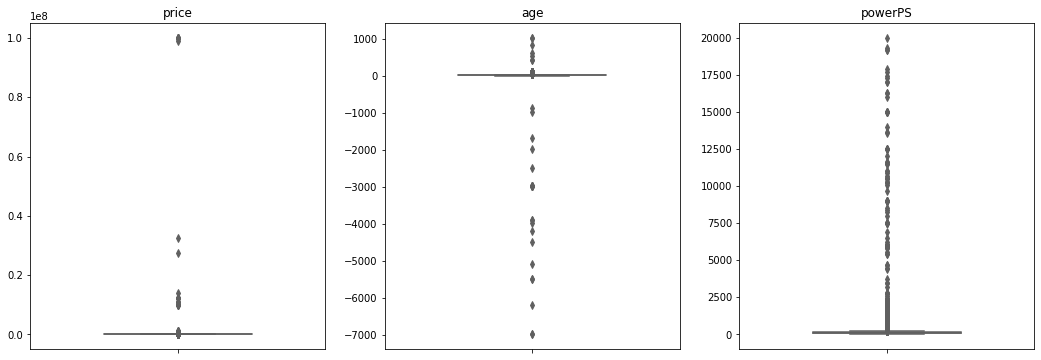

In [574]:
feats = ['price', 'age', 'powerPS']
fig, axes = plt.subplots(ncols=len(feats), nrows=1, figsize=(18,6))

for i, feat in enumerate(feats):
    sns.boxplot(df[feat], ax=axes[i], orient='v', width=0.5, color='#5DADE2');
    axes[i].set_ylabel('')
    axes[i].set_title(feat)


There are too many outliers. Let's define optimal cut-off thresholds. We will start from price. There are plenty of old and cheap cars at the dataset (like 15-20 years old), so we'll choose £100 as the lower bound. We will take £110,000 as the upper boundary. That is how much Porsche costs.

In [575]:
df = df[(df['price'] >= 100) & (df['price'] <= 110000)]

Let's take a look at the age. This is an important feature, because the age of the car is one of the key factors that affect its price. Obviously, the age can not be negative. Let's take a look at frequencies of cars older than 30 years to decide the lower bound for cutting off.

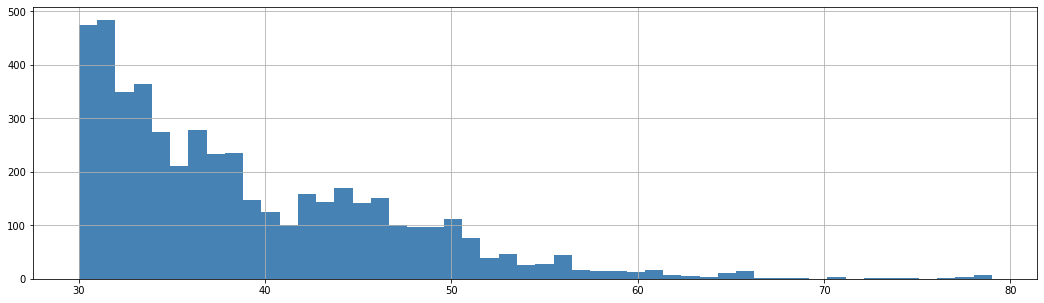

In [576]:
df.loc[(df['age'] >= 30) & (df['age'] < 80)]['age'].hist(bins=50, figsize=(18,5), color='steelblue');

Let's chose 50 years as lower bound because older cars have less than 100 instances in the dataset. 

In [577]:
df = df.loc[(df['age'] >= 0) & (df['age'] <=50)]

There are plenty of Porsches in the dataset with more than 500 horses. On the other hand, we have the Fiat cars with engines producing not more than 30 HP. Let's take (20, 600) as a range of acceptable data values for **powerPS** and build boxplots again.

In [578]:
df = df[(df['powerPS'] > 20) & (df['powerPS'] < 600)]

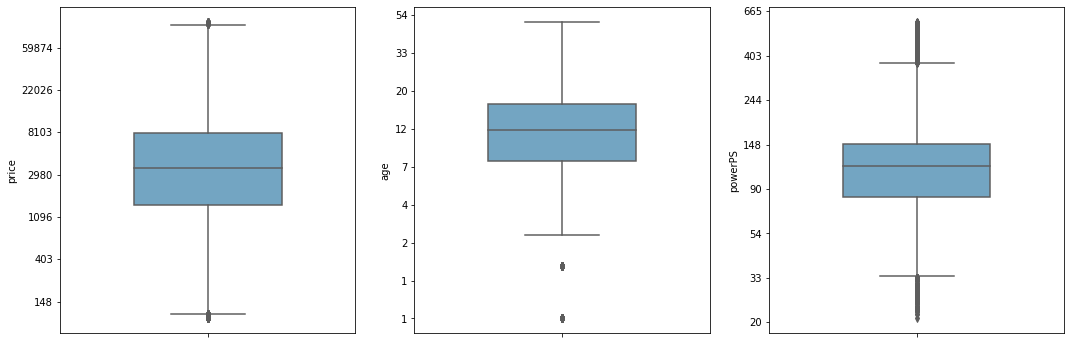

In [579]:
from matplotlib.ticker import FuncFormatter
feats = ['price', 'age', 'powerPS']

fig, axis = plt.subplots(ncols=3, figsize=(18, 6))
for i, feat in enumerate(feats):
    sns.boxplot(np.log(df[feat]), ax=axis[i], orient='v', width=0.5, palette='PuBuGn');# , color='#5DADE2');
    y_formatter = FuncFormatter(lambda x, pos: ('%i')%(np.exp(x)))
    axis[i].yaxis.set_major_formatter(y_formatter)

From the first boxplot we can conclude that about 50% of the used cars cost between £1500 and £8100. 
The second boxplot shows that a lot of old cars are represented. 
25% of cars are approximately from 19 to 50 years old, 50% - from 8 and 18, and 25% of relatively new cars. As we can see from the last boxplot, about 25% of the cars have horsepower more than 150 HP and 25% of them - less than 90 HP.

Let's take a look at the distribution of quantitative and binary features.

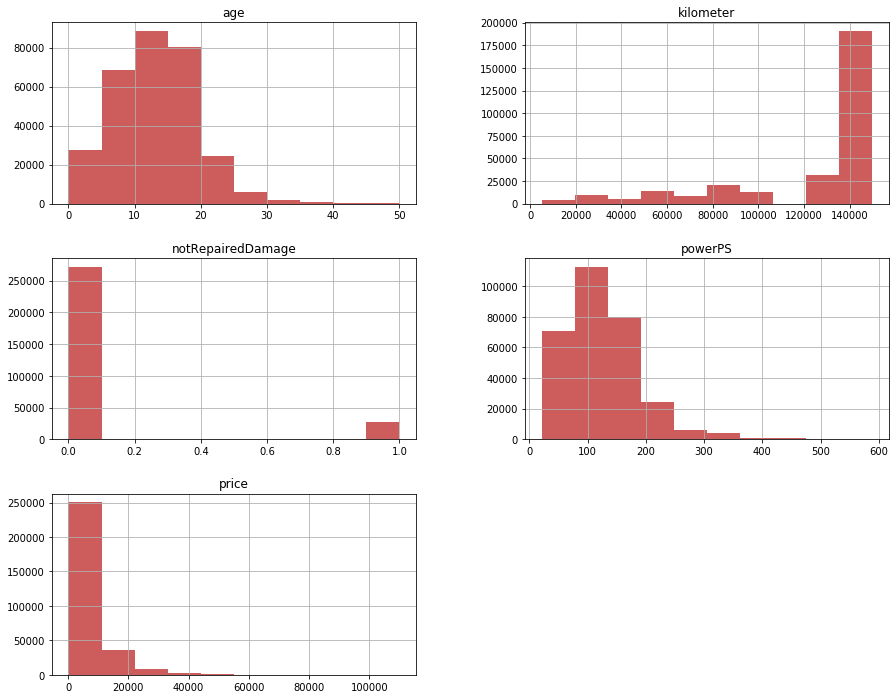

In [580]:
df.hist(figsize=(15, 12), color='indianred');

In [581]:
print('Percentage of cars with a mileage of 150,000 km: ', df[df['kilometer'] == 150000].shape[0] / df.shape[0])

Percentage of cars with a mileage of 150,000 km:  0.6366163993084066


In [582]:
df['kilometer'].describe()

count    299598.000000
mean     125554.326130
std       39037.533592
min        5000.000000
25%      100000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

Let's pay attention to the mileage (**kilometer** feature). Median and maximum are 150,000. 65% of cars have a mileage of 150,000 km and we have a quite screwed distribution. |

Now let's draw the correlation matrix

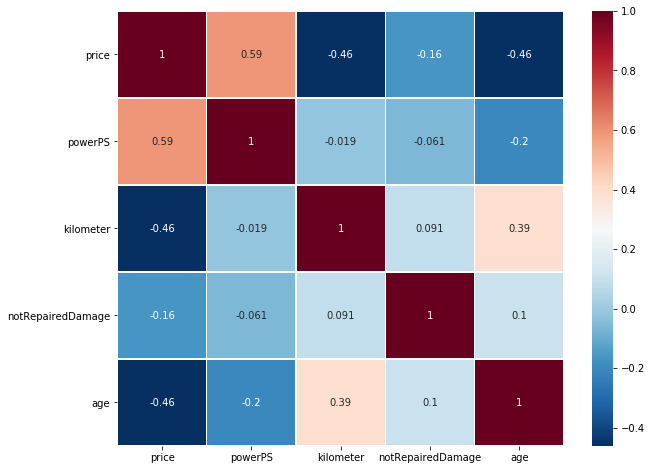

In [583]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, linewidths=.5, cmap='RdBu_r');

**price** correlates positively with **age** and **powerPS** and negatively with **kilometer**.

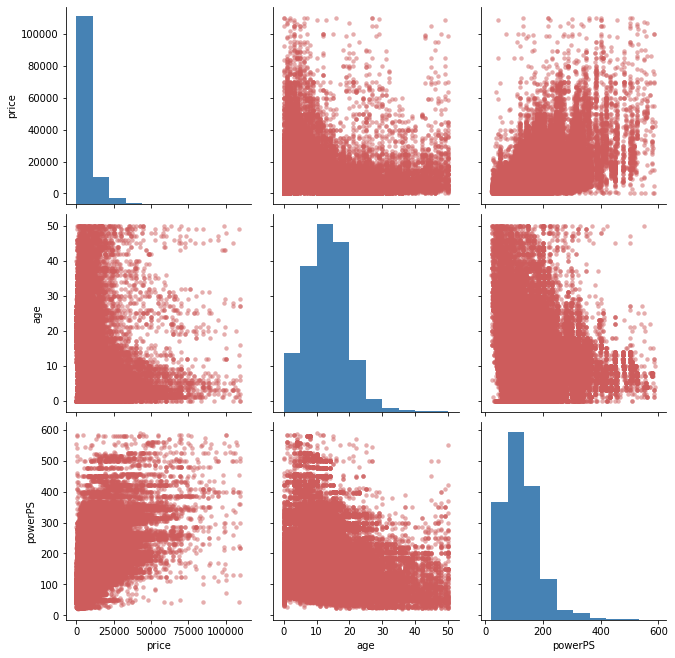

In [584]:
sns.pairplot(data=df[['price', 'age', 'powerPS']], size=3,
             plot_kws=dict(s=20, alpha=.5, linewidth=0, color='indianred'), 
             diag_kws=dict(color='steelblue')
            );

Let's look at some categorical features separately.

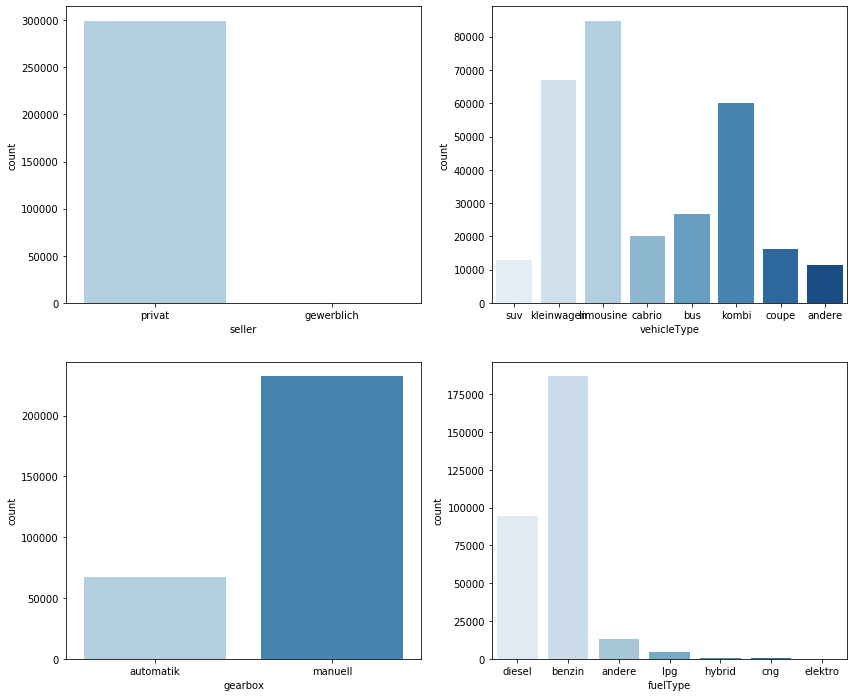

In [585]:
feats = ['seller', 'vehicleType', 'gearbox', 'fuelType']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14,12))
for idx, feat in enumerate(feats):
    ax = axes[int(idx/2), idx%2]
    sns.countplot(df[feat], ax=ax, palette='Blues')


It turns out that we only have one record with **seller** == 'gewerblich', so you can delete this attribute. fuelType other than diesel and benzin will be combined into a common group andere.

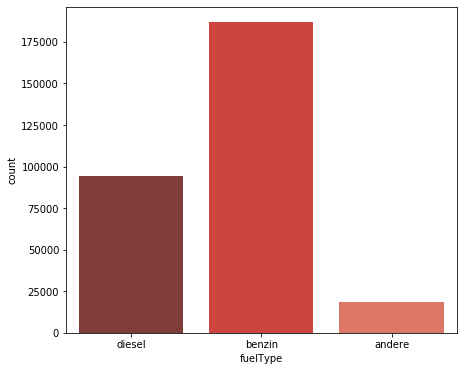

In [586]:
df.drop('seller', axis=1, inplace=True)
df['fuelType'].replace(['lpg', 'hybrid', 'cng', 'elektro'], 'andere', inplace=True)
plt.figure(figsize=(7,6))
sns.countplot(df['fuelType'], palette='Reds_d'); #RdBu, RdBu_r, RdGy, RdGy_r, RdPu, Rd

Let's look at the interaction of categorical features and prices.

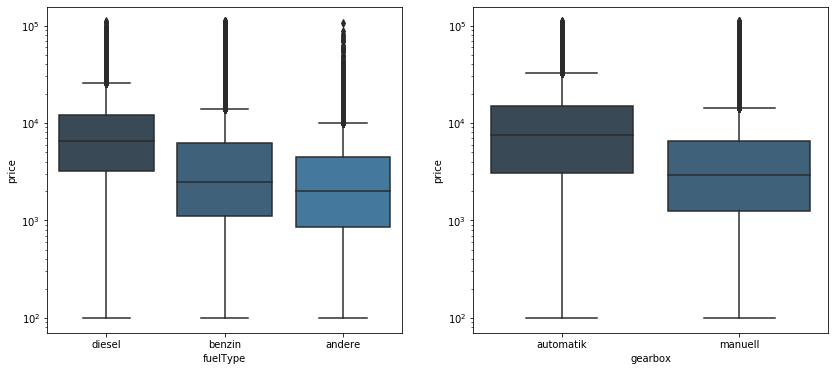

In [587]:
fig, axis = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(yscale='log'))
ax
feats = ['fuelType', 'gearbox']
for i, feat in enumerate(feats):
    sns.boxplot(x=feat, y='price', data=df, ax=axis[i]);

Cars with diesel engines are more expensive than petrol and others, and cars with automatic transmission are more expensive than with manual ones.

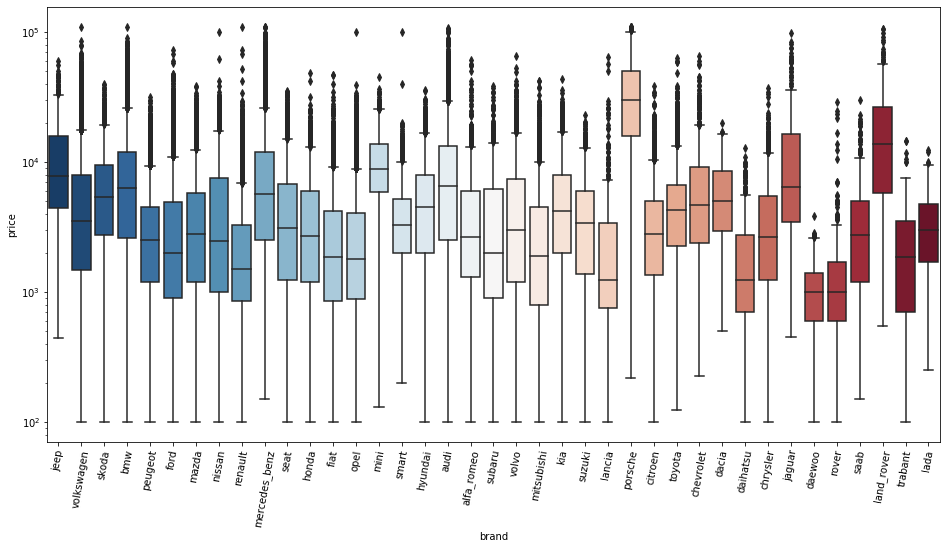

In [588]:
fig, axis = plt.subplots(figsize=(16, 8), )
axis.set_yscale('log')
sns.boxplot(x='brand', y='price', data=df, palette='RdBu_r');
axis.set_xticklabels(df['brand'].unique(), rotation=80);

From this picture, it follows that Porsche is significantly more expensive than other brands.

###  Data preprocessing 

Since we have date columns let's sort data by **dateCreated**. We need to make sure we are not leaking information from the future into the past. We will not randomly split the data into train and test sets. That would lead to, for example, making predictions about 2015 using data from 2016. Predicting the past with the future will cause us to overestimate the performance of the model.

In [607]:
df.sort_values(by=['dateCreated'], inplace=True)

y = df['price']
X = df.drop(['price'], axis=1)

Some cars have few or only entry in the data set.

In [608]:
models_count = X['model'].value_counts(ascending=True) 
print(models_count.loc[models_count == 1].head())
print('\nQuantity of models which have only entry in the data set:', models_count.loc[models_count == 1].shape[0])

9.3            1
460l           1
tts!!tausch    1
b4             1
vw             1
Name: model, dtype: int64

Quantity of models which have only entry in the data set: 303


Let's split the dataset into training and test data sets. Since we have some cars that have only entry in the data set so some of them can appear in train or test data set only. 

In [609]:
# X_train, X_test, y_train, y_test = \
#             train_test_split(X, y                            )
# split_idx = X_train.shape[0]

In [614]:
split_idx = int(X.shape[0] * 0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]

In [615]:
def obj2cat(X_trn, X_tst):
    for cat_feature in X_trn.columns[X_trn.dtypes == 'object']:
        X_trn[cat_feature] = X_trn[cat_feature].astype('category')  
        X_trn[cat_feature].cat.set_categories(X_trn[cat_feature].unique(), inplace=True)
        X_tst[cat_feature] = X_tst[cat_feature].astype('category')
        X_tst[cat_feature].cat.set_categories(X_trn[cat_feature].unique(), inplace=True)

    # there are car models in the test set that are not represented in the training set, 
    # let's replace the NaN with "andere" ("other").
    X_tst['model'].fillna(value='andere', inplace=True)
    return X_trn, X_tst

In [619]:
X_train, X_test = obj2cat(X_train, X_test)

In [620]:
X_train.shape, X_test.shape

((239678, 12), (59920, 12))

### Building basic models. Choosing evaluation metrics.

We'll build and compare linear regression and random forest.

In [621]:
# For basic models tet's remove features containing dates. 
X_train_base = X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)
X_test_base = X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)

#### Basic linear regression model

Lets's also apply one-hot encoding to categorical features, scale the features and train the linear regression model.

In [622]:
X_train_ohe = pd.get_dummies(X_train_base, columns=X_train_base.columns[X_train_base.dtypes == 'category'])
X_test_ohe = pd.get_dummies(X_test_base, columns=X_test_base.columns[X_test_base.dtypes == 'category'])

In [623]:
X_train_ohe.shape, X_test_ohe.shape

((239678, 810), (59920, 810))

In [624]:
scaler = StandardScaler().fit(X_train_ohe)
X_train_scaled = scaler.transform(X_train_ohe)
X_test_scaled = scaler.transform(X_test_ohe)

In [625]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We'll choose MAE as the evaluation metrics because of its interpretability. Let's also take a look at the coefficient of determination $R^2$. This measure is indicative of the level of explained variability in the data set. The closer it is to one the better.

In [626]:
y_preds_lr = lr.predict(X_test_scaled)
print('LinearRegression:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds_lr))
print('\tR2: ', r2_score(y_test, y_preds_lr))

LinearRegression:
	MAE:  2483.858342707466
	R2:  0.7343140381242146


On average, our model is wrong by £2484. It's a pretty big mistake. Let's plot real and predicted price for some cars.

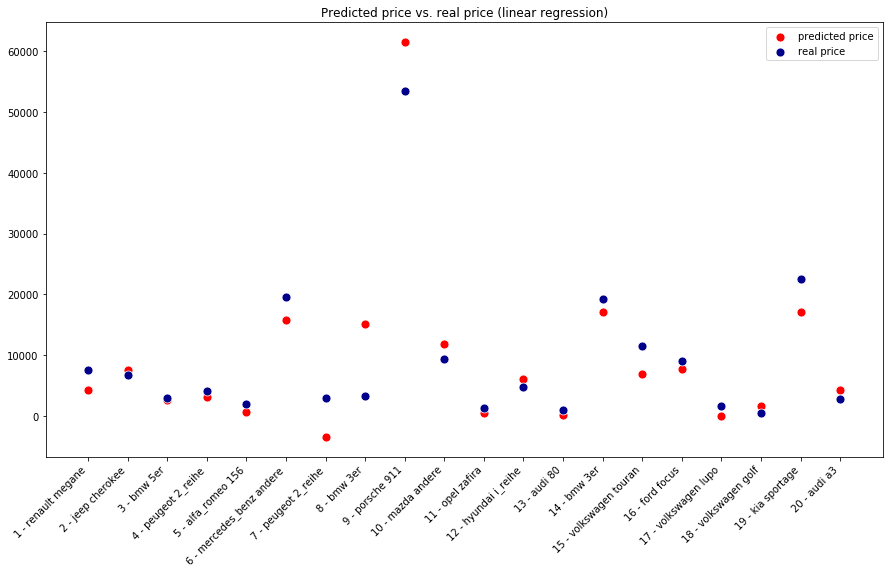

In [627]:
car_amount = 20
cars = [f'{i+1} - {model}' for i, model 
        in enumerate((df['brand'] + ' ' + df['model']).iloc[split_idx : split_idx+car_amount])]
plt.figure(figsize =(15, 8))
ax = sns.scatterplot(x=cars, y=y_preds_lr[:car_amount], color='red', label='predicted price', s=80);
sns.scatterplot(x=cars, y=y_test.iloc[:car_amount].values, color='darkblue', label='real price', s=80);
ax.set_title('Predicted price vs. real price (linear regression)')
ax.set_xticklabels(labels=cars, rotation=45, horizontalalignment='right');

Let's see how random forest will deal with the problem. 

#### Basic random forest

One-hot encoding works worse with RF. Significant amount of features makes training process much slower. Let's use label encoding for categorical features instead.   

In [712]:
# le = LabelEncoder()
for col in X_train_base.columns[X_train_base.dtypes == 'category']:
    le = LabelEncoder().fit(X_train_base[col])
    X_train_base[col] = le.transform(X_train_base[col])
    X_test_base[col] = le.transform(X_test_base[col])

In [721]:
rf = RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED)
rf.fit(X_train_base, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=17, verbose=0, warm_start=False)

In [722]:
y_preds_rf = rf.predict(X_test_base)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds_rf))
print('\tR2: ', r2_score(y_test, y_preds_rf))

RandomForestRegressor:
	MAE:  1231.13438093116
	R2:  0.9034446290819284


In [723]:
print('Predicted price range: (%.2f, %.2f) ' % (y_preds_rf.min(), y_preds_rf.max()))

Predicted price range: (105.10, 103020.15) 


In [724]:
print('Real price range: (%.2f, %.2f) ' % (y_test.min(), y_test.max()))

Real price range: (100.00, 110000.00) 


Looks like random forest managed better. The minimum and maximum values are very close. Price varies from £100 to £110K for targets and from £100 to £103K for predictions. Let's plot real and predicted price for some cars.

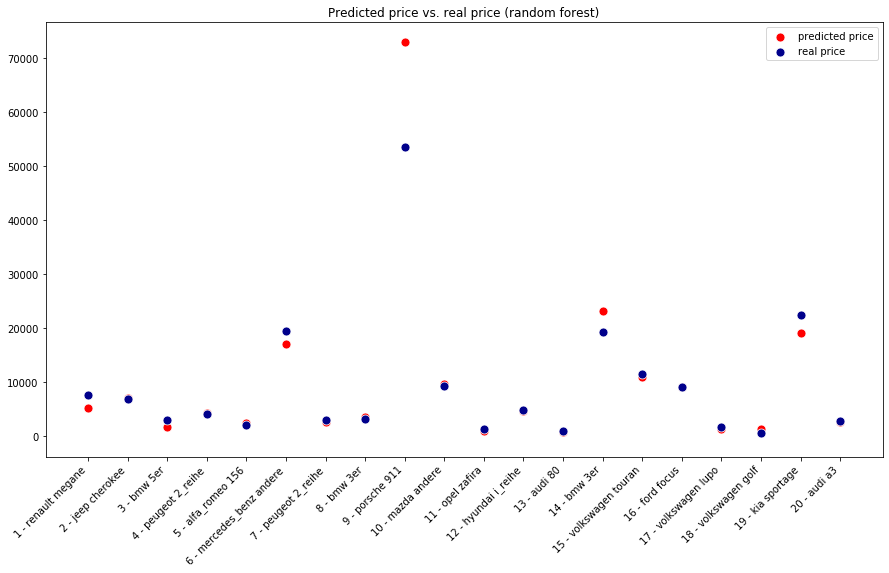

In [725]:
car_amount = 20
cars = [f'{i+1} - {model}' for i, model 
        in enumerate((df['brand'] + ' ' + df['model']).iloc[split_idx : split_idx+car_amount])]
plt.figure(figsize =(15, 8))
ax = sns.scatterplot(x=cars, y=y_preds_rf[:car_amount], color='red', label='predicted price', s=80);
sns.scatterplot(x=cars, y=y_test.iloc[:car_amount].values, color='darkblue', label='real price', s=80);
ax.set_title('Predicted price vs. real price (random forest)')
ax.set_xticklabels(labels=cars, rotation=45, horizontalalignment='right');

On the image above we can see that predictions are very close to real values. The more expensive car the larger error. It can be explained by that there are much more cheap cars in the data set than expensive ones. From the statistics represented below we can see that 75% of cars cost less than £8000.

In [300]:
y.describe()

count    299598.000000
mean       6223.674521
std        7709.920700
min         100.000000
25%        1450.000000
50%        3500.000000
75%        8000.000000
max      110000.000000
Name: price, dtype: float64

In [301]:
print('Cheap cars amount:', df.loc[df['price'] < 6000].shape[0])
print('Average price cars amount:', df.loc[(df['price'] >= 6000) & (df['price'] < 20000)].shape[0])
print('Expensive cars amount:', df.loc[df['price'] >= 20000].shape[0])

Cheap cars amount: 198545
Average price cars amount: 85429
Expensive cars amount: 15624


It can become a good feature. It's time for feature engineering.

###  Feature ingeneering

New features that can presumably correlate with the target: 
- **priceBracket** - price bracket
- **adUpDays** - amount of days the ad was published   

In [659]:
new_feats_train = pd.DataFrame(index=X_train.index)
new_feats_test = pd.DataFrame(index=X_test.index)

new_feats_train['adUpDays'] = (X_train['lastSeen'] - X_train['dateCrawled']).dt.days + 1
new_feats_test['adUpDays'] = (X_test['lastSeen'] -  X_test['dateCrawled']).dt.days + 1

new_feats_train.loc[y_train < 6000, 'priceBracket'] = 1
new_feats_train.loc[(y_train >= 6000) & (y_train < 20000), 'priceBracket'] = 2
new_feats_train.loc[y_train >= 20000, 'priceBracket'] = 3
new_feats_train['priceBracket'] = new_feats_train['priceBracket'].astype('category')

new_feats_test.loc[y_test < 6000, 'priceBracket'] = 1
new_feats_test.loc[(y_test >= 6000) & (y_test < 20000), 'priceBracket'] = 2
new_feats_test.loc[y_test >= 20000, 'priceBracket'] = 3
new_feats_test['priceBracket'] = new_feats_test['priceBracket'].astype('category')


# X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1, inplace=True)
# X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1, inplace=True)

Let's apply the log transformation to the new features, scale data and add second degree polynomials. 

In [75]:
# new_feats_train['kilPerYear_log'] = np.log1p(new_feats_train['kilPerYear'])
# new_feats_test['kilPerYear_log'] = np.log1p(new_feats_test['kilPerYear'])

# new_feats_train['powerPS_log'] = np.log1p(X_train['powerPS'])
# new_feats_test['powerPS_log'] = np.log1p(X_test['powerPS'])

In [47]:
# scaler = StandardScaler().fit(X_train[['kilometer', 'yearOfRegistration']])
# features_scaled_train = scaler.transform(X_train[['kilometer', 'yearOfRegistration']])
# features_scaled_test = scaler.transform(X_test[['kilometer', 'yearOfRegistration']])

In [93]:
# X_train.columns[X_train.dtypes == 'category']

Index([], dtype='object')

In [66]:
X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1, inplace=True)
X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1, inplace=True)

In [416]:
X_train_base = X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)
X_test_base = X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)

In [734]:
from sklearn.preprocessing import OneHotEncoder

Let's see if the new features help to improve quality .

In [939]:
from sklearn.model_selection import TimeSeriesSplit

def cv_mean_scores(X, y, n_splits=5, pipeline=['ohe', 'stdscale','lr']):
    """
        Evaluate MAE and R2 scores by cross-validation using Time Series cross-validator 
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
        y : pandas Series, shape = [n_samples]
            Target values.
        n_splits : int, default=5:
            Number of splits. Must be at least 2.
        pipeline: list of str, default = ['ohe', 'stdscale','lr'] 
            Pipeline of transforms to apply to X with a final estimator.
            'ohe' - ohe hot encoder, 'stdscale' - StandardScaler, 'poly' - PolynomialFeatures,
            'label' - LabelEncoder, 'lr' - LinearRegression, 'rf' - RandomForestRegression
        
        Returns
        -------
        tuple_of_mean_scores: tuple
            Tuple containing mean of MAE scores and mean of R2 scores   
        """
    tscv = TimeSeriesSplit(n_splits)
    mae_scores = []
    r2_scores = []
    for train_indices, valid_indices in tscv.split(X):
        X_train, X_valid = X.iloc[train_indices], X.iloc[valid_indices]
        y_train, y_valid = y.iloc[train_indices], y.iloc[valid_indices]
        X_train, X_valid = obj2cat(X_train, X_valid)
        noncat_feats = X_train.columns[X_train.dtypes != 'category']
        cat_feats = X_train.columns[X_train.dtypes == 'category']
        if 'ohe' in pipeline:
#             X_train_cat = X_train[X_train.columns[X_train.dtypes == 'category']]
#             ohe = OneHotEncoder(sparse=False).fit(X_train_cat)
#             X_train_cat = ohe.transform(X_train_cat)
#             X_valid_cat = ohe.transform(X_valid[X_valid.columns[X_valid.dtypes == 'category']])
#             X_train = np.concatenate([X_train_cat, X_train[X_train.columns[X_train.dtypes != 'category']]], axis=1)
#             X_valid = np.concatenate([X_valid_cat, X_valid[X_valid.columns[X_valid.dtypes != 'category']]], axis=1)
            X_train = pd.get_dummies(X_train, columns=cat_feats)
            X_valid = pd.get_dummies(X_valid, columns=cat_feats)
            cat_feats = X_train.columns[X_train.columns.str.contains('|'.join(cat_feats))] #new categorical columns
            
        if 'stdscale' in pipeline:
            scaler = StandardScaler().fit(X_train[noncat_feats])
            X_train = pd.concat([X_train[cat_feats], 
                                pd.DataFrame(scaler.transform(X_train[noncat_feats]), columns=noncat_feats,
                                            index=X_train.index)], axis=1)
            X_valid = pd.concat([X_valid[cat_feats], 
                                 pd.DataFrame(scaler.transform(X_valid[noncat_feats]), columns=noncat_feats,
                                             index=X_valid.index)], axis=1)
            
        if 'poly' in pipeline:
            poly = PolynomialFeatures(2).fit(X_train[noncat_feats])
            X_train = np.concatenate([X_train[cat_feats], poly.transform(X_train[noncat_feats])], axis=1)
            X_valid = np.concatenate([X_valid[cat_feats], poly.transform(X_valid[noncat_feats])], axis=1)
#             X_train = poly.fit_transform(X_train)
#             X_valid = poly.transform(X_valid)
                    
        if 'label' in pipeline:
            for feat in cat_feats:
                le = LabelEncoder().fit(X_train[feat])
                X_train[feat] = le.transform(X_train[feat])
                X_valid[feat] = le.transform(X_valid[feat])
                
        if 'lr' in pipeline:
            model = LinearRegression()
                
        if 'rf' in pipeline:
            model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1)    
        
                
        model.fit(X_train, y_train)
        y_preds = model.predict(X_valid)
        mae_scores.append(mean_absolute_error(y_valid, y_preds))
        r2_scores.append(r2_score(y_valid, y_preds))
#         print('\tMAE: ', mean_absolute_error(y_valid, y_preds))
#         print('\tR2: ', r2_score(y_valid, y_preds))

    return np.mean(mae_scores), np.mean(r2_scores)

In [940]:
split_idx = int(X.shape[0] * 0.8)
X_train, y_train = X.iloc[:split_idx], y.iloc[:split_idx]
X_test, y_test = X.iloc[split_idx:], y.iloc[split_idx:]

In [941]:
X_train = X_train.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)
X_test = X_test.drop(['dateCrawled','dateCreated', 'lastSeen'], axis=1)

In [942]:
for col in new_feats_train.columns:
    X_train_new = pd.concat([X_train, new_feats_train[col]], axis=1)
    mean_scores = cv_mean_scores(X_train_new, y_train, pipeline=['ohe', 'stdscale','lr'])
    print(f'Scores after adding a new feature {col}:' )
    print('\tLinearRegression:')
    print(f'\t\tMAE: {mean_scores[0]}, R2: {mean_scores[1]}')
    mean_scores = cv_mean_scores(X_train_new, y_train, pipeline=['label', 'rf'])
    print('\tRandomForest:')
    print(f'\t\tMAE: {mean_scores[0]}, R2: {mean_scores[1]}')

Scores after adding a new feature adUpDays:
	LinearRegression:
		MAE: 2431.4807220998346, R2: 0.7219499864347436
	RandomForest:
		MAE: 1263.1186193384979, R2: 0.8800321410217096
Scores after adding a new feature priceBracket:
	LinearRegression:
		MAE: 1632.1788933223913, R2: 0.8550769330757241
	RandomForest:
		MAE: 1028.738141662937, R2: 0.9314258345239379


As we can see **adUpDays** doesn't affect or even makes results worse, while **priceBracket** improve scores significantly. Random forest model looks better comparing with linear one again. Let's try to add polynomial features to our linear model and check the scores on cross validation. 

In [943]:
X_train_poly = pd.concat([X_train, new_feats_train['priceBracket']], axis=1)
mean_scores = cv_mean_scores(X_train_poly, y_train, pipeline=['ohe', 'stdscale', 'poly', 'lr'])
print('LinearRegression:')
print(f'\tMAE: {mean_scores[0]}, R2: {mean_scores[1]}')

LinearRegression:
	MAE: 1450.4830554842788, R2: 0.8801270027841006


In [51]:
y_preds_lr = lr.predict(X_test_new) 
print('LinearRegression:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds_lr))
print('\tR2: ', r2_score(y_test, y_preds_lr))

LinearRegression:
	MAE:  0.3164375199201237
	R2:  0.8529288483736284


The quality of the linear model improved, but it is still worse than the base random forest, so let's focus on the latter.

Let's see how adding the new feature **adUpDays** and **kilPerYear** affects the quality of the model.

In [76]:
X_train_new = pd.concat([X_train, new_feats_train[['kilPerYear']]], axis=1)
X_test_new = pd.concat([X_test, new_feats_test[['kilPerYear']]], axis=1)

In [77]:
%%time
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train_new, y_train)

ValueError: could not convert string to float: 'kleinwagen'

In [54]:
y_preds = rf.predict(X_test_new)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

RandomForestRegressor:
	MAE:  0.2725363034987626
	R2:  0.8762494540991046


In [55]:
X_train_new = pd.concat([X_train, new_feats_train[['adUpDays']]], axis=1)
X_test_new = pd.concat([X_test, new_feats_test[['adUpDays']]], axis=1)

In [56]:
%%time
rf = RandomForestRegressor(random_state=RANDOM_SEED)
rf.fit(X_train_new, y_train)

CPU times: user 7min 51s, sys: 344 ms, total: 7min 51s
Wall time: 7min 51s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=17, verbose=0, warm_start=False)

In [57]:
y_preds = rf.predict(X_test_new)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

RandomForestRegressor:
	MAE:  0.26811616619525774
	R2:  0.8808346118292569


The random forest model improved slightly with the addition of **adUpDays**. Adding **kilPerYear** did not affect the quality in any way.

As you can see from the graph below, the most important feature for the random forests happened to be the year of registration, the second one was the engine power, and the third one indicates that the car does not need to be repaired.

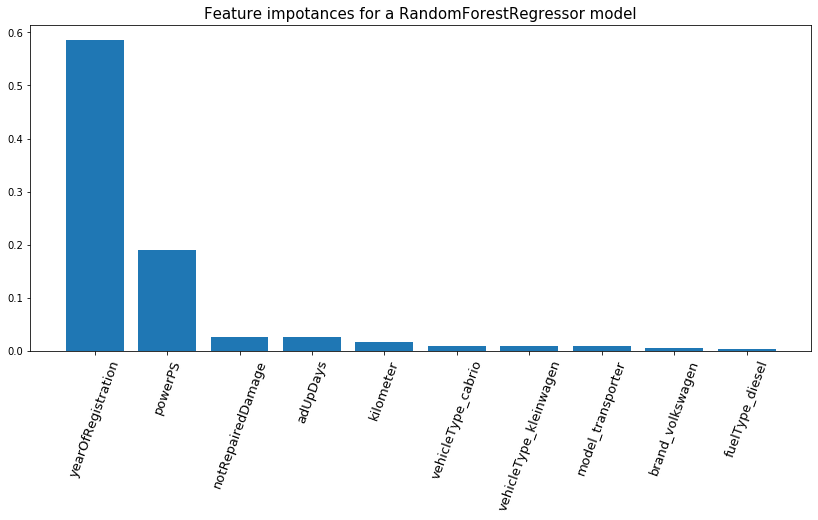

In [58]:
features = X_train_new.columns
importances = rf.feature_importances_
num_to_plot = 10
indices = np.argsort(importances)[::-1][:num_to_plot]
 
plt.figure(figsize=(14,6))
plt.title('Feature impotances for a RandomForestRegressor model', size=15)
bars = plt.bar(range(num_to_plot), importances[indices], align="center")
ticks = plt.xticks(range(num_to_plot), features.values[indices[:]], rotation=70, size=13)

###  Validation curves

Let's try to improve the result of a random forest. First, let's look at how validation curves behave when changing the main parameters.

Let's start with the number of trees:

In [59]:
from sklearn.model_selection import validation_curve, KFold
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [60]:
def valid_curves_plot(hyperparam, param_range):
    param_range = param_range
    train_scores, test_scores = validation_curve(RandomForestRegressor(random_state=RANDOM_SEED), 
                                X_train_new, y_train, param_name=hyperparam, param_range=param_range, 
                                cv=kf, n_jobs=-1, scoring='r2')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(9,6))
    plt.title('Validation curves for a RandomForestRegressor model')
    plt.xlabel(hyperparam)
    plt.ylabel('R2')
    plt.ylim(0.8, 1.0)
    plt.fill_between(param_range, train_scores_mean - train_scores_std, \
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.plot(param_range, train_scores_mean, label='Training error', color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, \
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.plot(param_range, test_scores_mean, label='Validation error', color="g")

    plt.legend(loc="best")
    plt.xticks(param_range)
    plt.show()

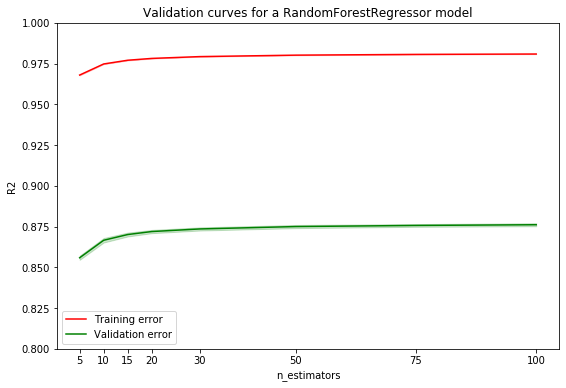

CPU times: user 545 ms, sys: 373 ms, total: 919 ms
Wall time: 31min 28s


In [61]:
%%time
valid_curves_plot(hyperparam='n_estimators', param_range=[5, 10, 15, 20, 30, 50, 75, 100])

As you can see, when you reach 30 trees, the accuracy of the model on the test goes to the asymptote. 

Let's see what regularization parameters to add to the model to prevent over-training.
Let's see how the model behaves depending on the maximum depth parameter – `max_depth`.

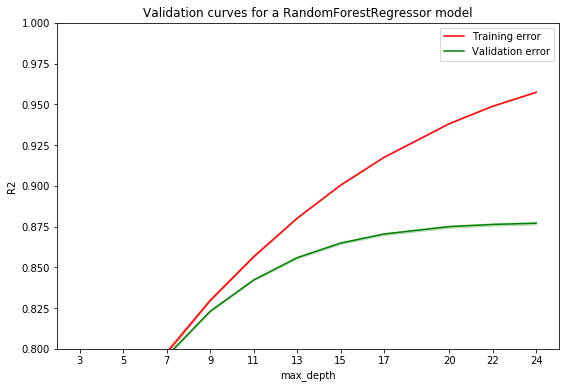

CPU times: user 781 ms, sys: 467 ms, total: 1.25 s
Wall time: 1h 18min 15s


In [62]:
%%time
valid_curves_plot(hyperparam='max_depth', param_range=[3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24])

As you can see, it makes no sense to build trees with a depth of more than 22, the quality on the test goes to the asymptote.<br / > 
<br / >
Let's build validation curves for the parameter `min_samples_leaf` .

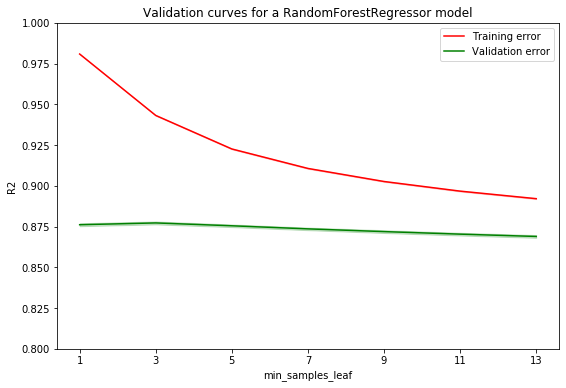

CPU times: user 560 ms, sys: 294 ms, total: 854 ms
Wall time: 1h 1min 25s


In [63]:
%%time
valid_curves_plot(hyperparam='min_samples_leaf', param_range=[1, 3, 5, 7, 9, 11, 13])

As we can see in the test, the maximum quality is achieved if the minimum number of objects in the sheet is 3. 
<br/>
<br/>
The parameter `max_features` determines the number of random features from the `n` source ones. For regression problems, we recommend using $\frac{n}{3}$. Let's define the optimal parameter for our case.

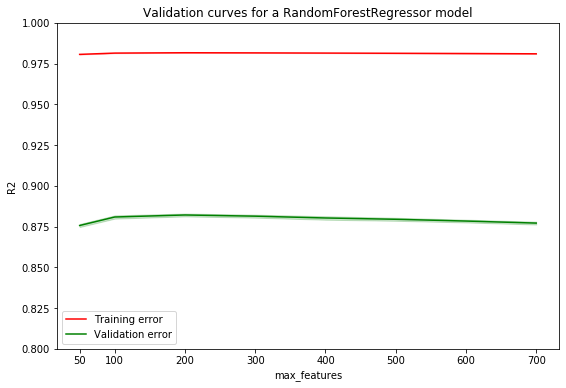

CPU times: user 531 ms, sys: 340 ms, total: 872 ms
Wall time: 47min 2s


In [64]:
%%time
valid_curves_plot(hyperparam='max_features', param_range=[50, 100, 200, 300, 400, 500, 600, 700])

Looks like **max_features** = 200 is the best choice.

In [69]:
X_train.shape

(205044, 761)

###  Cross validation and parameter tuning

In [65]:
from sklearn.model_selection import GridSearchCV

Now, let's identify the parameters for the tree using cross validation.

In [ ]:
# We'll tune the maximum number of features used at each split, the minimum number of samples in a leaf and
# the maximum depth
parameters = {'max_features': [100,200, 300, 400, 500], 
              'min_samples_leaf': [1, 3, 5, 7], 
              'max_depth': [13, 15, 17, 20, 22, 24]}
rfc = RandomForestRegressor(n_estimators=30, random_state=RANDOM_SEED, n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=kf)
gcv.fit(X_train_new, y_train)

Let's list the best parameters and the corresponding mean accuracy from cross-validation

In [ ]:
gcv.best_params_, gcv.best_score_

In [ ]:
gcv.best_estimator_

### Predictions for test dataset

Let's train a random forest with optimal hyperparameters and get predictions for the test set.

In [ ]:
%%time
gcv.best_estimator_.fit(X_train_new, y_train)

In [ ]:
y_preds = gcv.best_estimator_.predict(X_test_new)
print('RandomForestRegressor:')
print('\tMAE: ', mean_absolute_error(y_test, y_preds))
print('\tR2: ', r2_score(y_test, y_preds))

Нам удалось выиграть "аж" 0.01 на обоих метриках.

###  Model estimation

Let's translate the target attribute back to kilometers and see how well our model worked on the test set. First, let's compare real and predicted prices for several examples.

In [ ]:
y_test_preds = pd.DataFrame({'y_true': np.exp(y_test) - 1,
                           'y_preds': np.exp(y_preds) - 1})
y_test_preds['y_true'] =round(y_test_preds['y_true'], 2)
y_test_preds['y_preds'] =round(y_test_preds['y_preds'], 2)
y_test_preds['diff'] = np.absolute(y_test_preds['y_true'] - y_test_preds['y_preds'])
y_test_preds.head(20).T

As you can see, the model is quite wrong in some cases, but in General, the patterns in the data are revealed and the result looks good. The chart below shows the dispersion of the real vs price . the predicted price relative to the identity line (red line). It is clearly seen that the higher the price, the more the model is mistaken and the tendency to underestimate is visible. This is obviously due to insufficient data on expensive cars.

In [ ]:
from ggplot import *

ggplot(y_test_preds, aes(x='y_true',y='y_preds')) + \
    geom_point(color='blue')  + \
    xlim(-1e03,  1e+05) + ylim(-1e03, 1e+05) + \
    ggtitle("RandomForestRegressor model") + \
    xlab("True price") + ylab("Predicted price") + \
    geom_abline(intercept=0, size=2, color='red')

We also see some strong emissions at the very beginning. Looking at the data, it becomes clear that the model predicts a higher cost of cars billed for "nothing". Perhaps the sellers indicate a low price to attract buyers, or maybe they forgot to indicate that the car needs repair.

In [ ]:
y_test_preds.sort_values('y_true').head()

###  Learning curves

Let's build learning curves for the entire amount of data.

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
%%time

plt.figure(figsize=(12, 8))
plt.title("Learning curves for a RandomForestRegressor model")
plt.xlabel("Training examples")
plt.ylabel("MSE")
train_sizes, train_scores, test_scores = \
            learning_curve(RandomForestRegressor(max_depth=24,
                                                max_features=200,
                                                min_samples_leaf=1,
                                                n_estimators=30, n_jobs=-1,
                                                random_state=RANDOM_SEED), 
                            np.concatenate([X_train, X_test]),
                            np.concatenate([y_train, y_test]),
                            cv=kf,
                            train_sizes=np.linspace(0.1, 1.0, 5),
                            random_state=RANDOM_SEED)
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training error")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Validation error")
plt.legend()

Большое расстояние между кривыми указывает на переобучение. 

### Выводы 

The raw data contained many omissions and outliers. We needed to do a lot of processing and filtering. For categorical characteristics, we used one-hot encoding. The target attribute had a strongly skewed distribution, so we applied a logarithmic transformation to it.

We compared the two models and came to the conclusion that a linear model with polynomial features gives MAE: 0.31 and $R^2$: 0.85, while a random forest "out of the box" immediately gave MAE: 0.28 and $R^2$: 0.87. Unfortunately, we were not able to synthesize features that improve this random forest result. Setting up hyperparameters resulted in a slight increase in quality: MAE: 0.27 and $R^2$: 0.88.

Given that the random forest has shown good results, it would be remiss of me not to focus the boost on our data. I used the Python implementation of XGBoost, adjusted the parameters using hyperopt, but did not get any significant improvements, so I decided not to bother readers and omitted the calculations.

Thus, we can conclude that the random forest worked well for this task.

Based on the learning curves, we can draw a conclusion to improve the model.:
- increase the sample size;
- reduce the complexity of the model. This can be achieved if you use a smaller set of features or increase regularization (for example, you can reduce the depth of trees or increase the minimum number of objects in a sheet).